train size= 3224
validation size= 570
50
Epoch 1/50, Train Loss: 1.6039144829207777, Train Acc: 27.915632754342433%, Val Loss: 1.6106543011135526, Val Acc: 30.526315789473685%
Epoch 2/50, Train Loss: 1.3879704662397796, Train Acc: 33.28163771712159%, Val Loss: 1.9450500806172688, Val Acc: 26.31578947368421%
Epoch 3/50, Train Loss: 1.3964381942562027, Train Acc: 33.34367245657568%, Val Loss: 1.3259583181805081, Val Acc: 36.84210526315789%
Epoch 4/50, Train Loss: 1.300776675635693, Train Acc: 37.593052109181144%, Val Loss: 1.293533166249593, Val Acc: 37.89473684210527%
Epoch 5/50, Train Loss: 1.2224215105468152, Train Acc: 42.77295285359802%, Val Loss: 1.2197039789623685, Val Acc: 40.87719298245614%
Epoch 6/50, Train Loss: 1.1265673403646432, Train Acc: 47.36352357320099%, Val Loss: 1.2552842828962538, Val Acc: 44.3859649122807%
Epoch 7/50, Train Loss: 1.0207112209469664, Train Acc: 50.71339950372209%, Val Loss: 1.0478548540009394, Val Acc: 48.771929824561404%
Epoch 8/50, Train Loss: 0.9

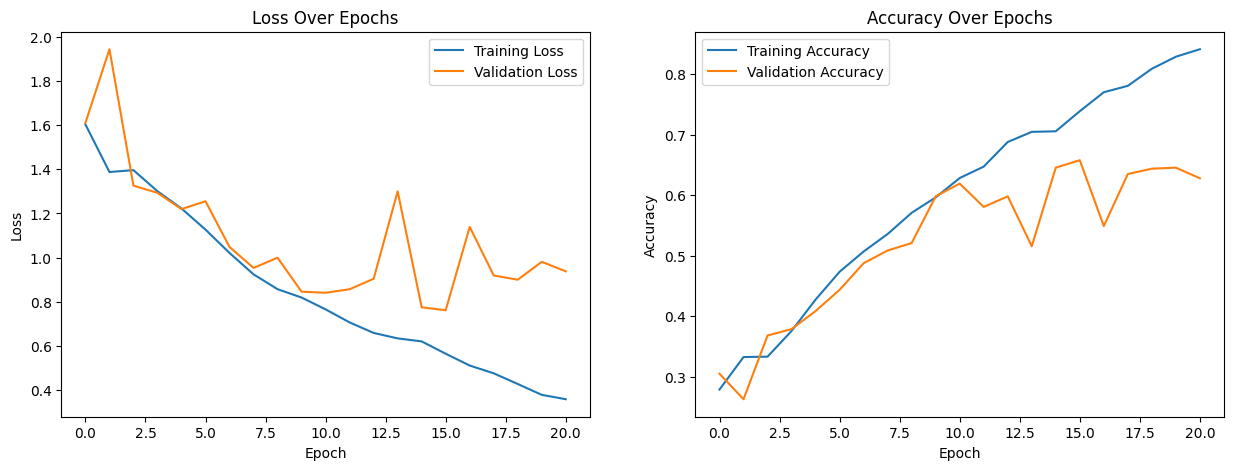

In [1]:
import torch
from torch import optim, nn

from Model.model import MultiLayerFCNet
from DataLoder.dataLoader import custom_loader
from TrainUtils.train_utils import train_epoch, validate_epoch
import Config.config as config
from Utils.utils import save_model, plot_training_results

if __name__ == '__main__':

    train_loader, val_loader = custom_loader(config.BATCH_SIZE, config.TRAIN_DATA_PATH)

    model = MultiLayerFCNet(config.INPUT_SIZE, config.HIDDEN_SIZE, config.OUTPUT_SIZE)
    model = nn.DataParallel(model)
    model.to(config.DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), config.LEARNING_RATE)
    best_acc = 0
    no_improve_epochs = 0
    patience = 5  # Set the patience for early stopping

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    print(config.EPOCHS)

    for epoch in range(config.EPOCHS):
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, config.DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            no_improve_epochs = 0
            save_model(model, config.STOP_MODEL_SAVE_PATH)
        else:
            no_improve_epochs += 1
            
        
        if no_improve_epochs >= patience:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Train Loss: {train_loss}, Train Acc: {train_accuracy * 100}%, Val Loss: {val_loss}, Val Acc: {val_accuracy * 100}%")

    # Plotting using utility function
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)
